<a href="https://colab.research.google.com/github/obarnstedt/LINdoscope2023/blob/main/notebooks/place_cell_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Created on Wed Aug  30 14:27:32 2023
#@author: Felix Kuhn (LIN)
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
#!pip install mpld3
import mpld3 #install conda-forge
#mpld3.enable_notebook() # allows zooming in plots
#!pip install --upgrade matplotlib
from matplotlib import gridspec as gridspec
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 300
import math
import scipy
from scipy.optimize import curve_fit
%matplotlib inline
from scipy import signal as sig
from shapely.geometry import Polygon #install conda-forge
!pip install uncertainties
import uncertainties as unc #install pip
import uncertainties.unumpy as unp
import sys
sys.path.append("../../src/W0D6_2P_Analysis")
import pandas as pd
from tqdm import tqdm
from scipy.signal import savgol_filter
%config InlineBackend.figure_format = 'svg'
plt.style.use('dark_background')
#!pip install --upgrade bokeh==2.4.3
#mport bokeh
import pandas as pd
#try:
    #import pandas_bokeh
#except:
    #!pip install pandas-bokeh
   # import pandas_bokeh

#from bokeh.plotting import curdoc, figure, show

#pandas_bokeh.output_notebook()
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")



Mounted at /content/drive



#Import sample file:



In [3]:
filepath = '/content/drive/MyDrive/LINdoscope2023_analysis/sample_data/2P_dCA1_treadmill/calcium_behaviour.h5'

behaviour = pd.read_hdf(filepath) # behavioural signal synched
calcium = np.load('/content/drive/MyDrive/LINdoscope2023_analysis/sample_data/2P_dCA1_treadmill/calcium_signal_S.npy') # calcium signal synched




In [4]:
cell_num = len(behaviour['cell'].keys())
print('number of cells = ' + str(cell_num))

number of cells = 977


# The behavioural paradigm:

A mouse runs on a linear treadmill treadmill with 360 cm in length. The treadmill is divided into 6 60 cm long zones with different tactile and visual cues. The mouse has learned to receive a water reward between 330cm and 360cm upon licking on a small pipe.

 Since we are interested in the spatial information that is contained by the neurons' activity in this tutorial, let's assume that for now we only have access to the position across time (mouse's position between 0 and 360) synchronized with a deconvolved calcium signal that is already synced to the position recording.





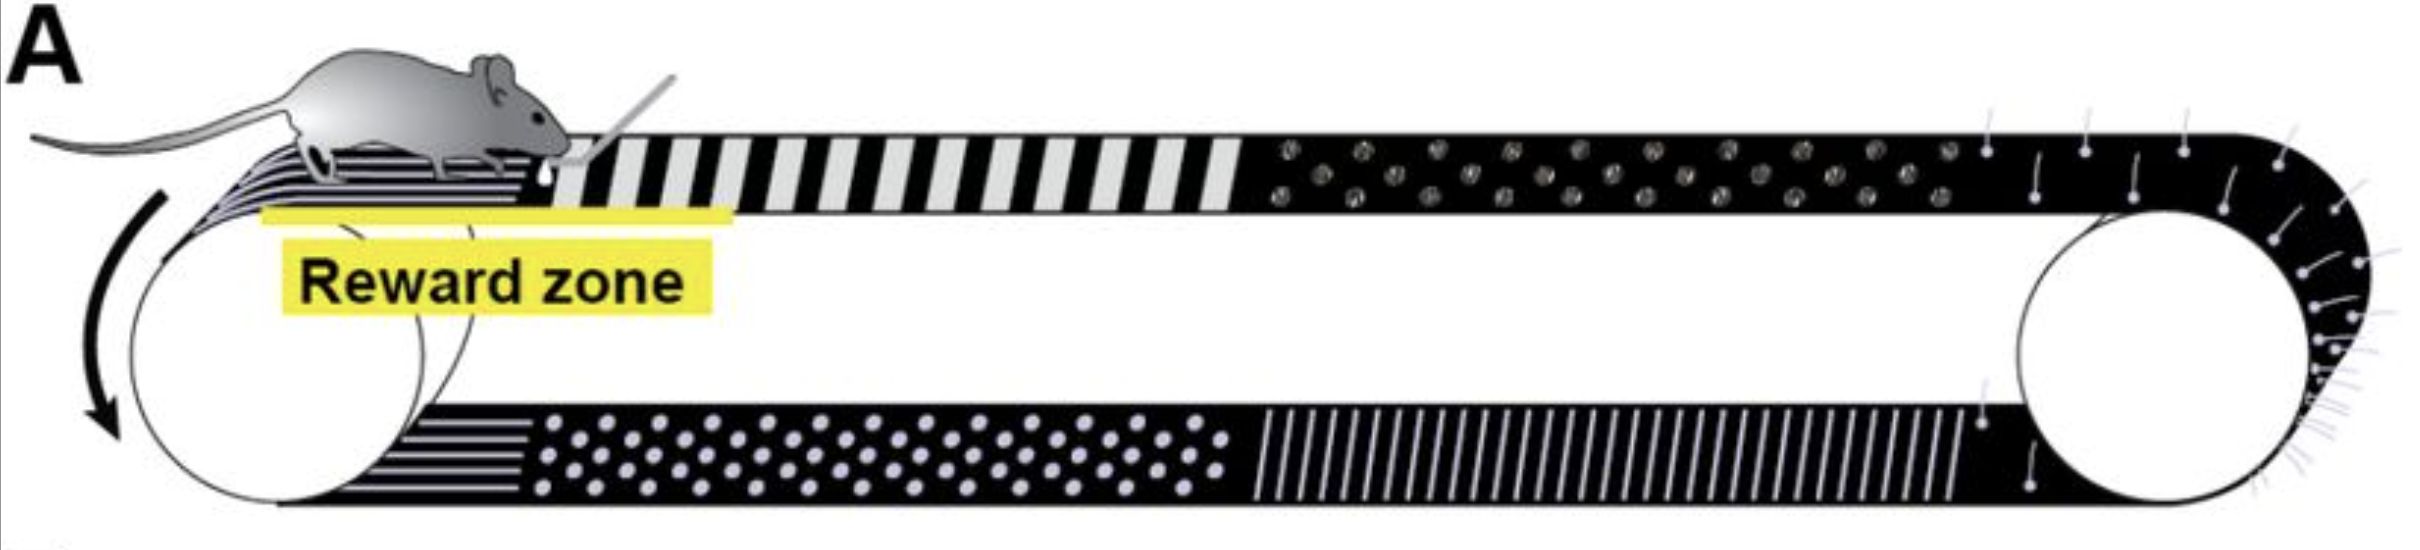

In [5]:
# somehow it doesnt display in markdown..
from IPython.display import Image
Image(filename='/content/drive/MyDrive/LINdoscope2023_analysis/sample_data/2P_dCA1_treadmill/treadmill.png')

Lets load the behavioural data. For now let's pretend we only have information about position time and laps.

In [6]:
time = behaviour['behaviour']['Time_s']
position = behaviour['behaviour']['Position']
lap = behaviour['behaviour']['Lap'] -38 # couting of example dataset starts with 38



Let's plot the position over time

Text(0.5, 1.0, 'Position')

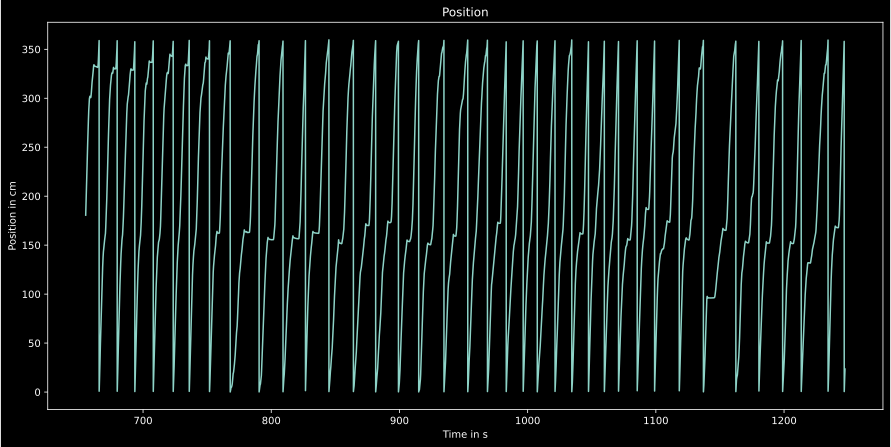

In [7]:
%matplotlib inline
# plot position
plt.figure(figsize=(15,7))
plt.plot(time,position,label='Position in cm')
plt.xlabel('Time in s')
plt.ylabel('Position in cm')
plt.title('Position')



#Let's infer the velocity of the animal from position and time using a Kalman filter

In simple terms, think of the Kalman filter as a smart algorithm that continually refines its estimate of the animal's velocity at each time point by considering both its observed measurement of position and a prediction it makes from previous measurements about where it should be. -> It's like trying to keep track of a moving object's position and velocity, even when you have noisy data or uncertain knowledge of how the object behaves.

![Image](https://www.researchgate.net/publication/354627620/figure/fig4/AS:1080241044889618@1634560943438/Working-principle-of-Kalman-filter.jpg)

For the calculation we first have to transform position into distance such that there will be no artifacts when the position jumps from 360 cm to 0 cm.


Text(0.5, 1.0, 'Distance traveled over time')

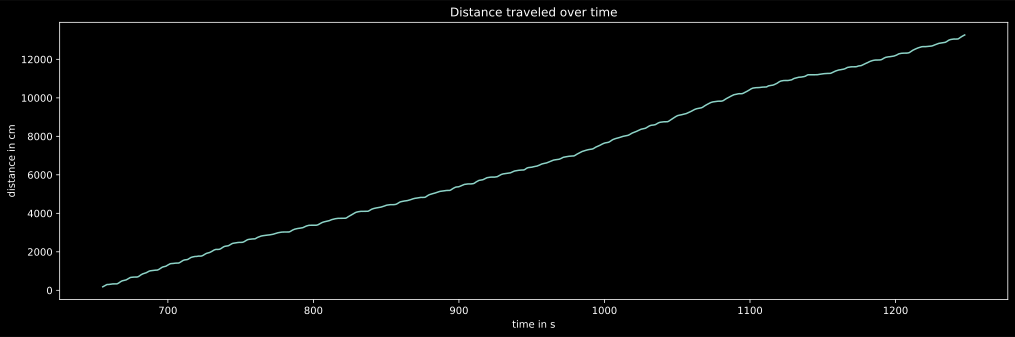

In [8]:
distance = np.unwrap(position) # removes jumps in a sequence of phase angles (360 -> 0)

plt.figure(figsize = (17,5))
plt.plot(time,distance)
plt.xlabel('time in s')
plt.ylabel('distance in cm')
plt.title('Distance traveled over time')


In [9]:
#calculate mean timesteps of measurement:
dt = np.mean(np.diff(time))

# Initialize mean of state variable x.
# First row is initial position and second row is initial velocity.
#    x  x'


x = np.array([[distance[0]], [0]], ndmin=2)  # Initial State (Location and velocity)
P = np.array([[1, 0], [0, 100]])  # Initial Uncertainty
A = np.array([[1, dt], [0, 1]])  # Transition Matrix -> the new position is the old position plus the old velocity multiplied by the time step (dt))

# Measurement function
H = np.array([1, 0], ndmin=2) # This matrix H is the measurement function.
# It defines how you relate the state (position and velocity) to your actual measurements.
# In this case, it's saying that you directly measure the position and not the velocity.

# measurement noise covariance; 1e-3 recommended, smaller values for precise onset, larger for smooth velocity
R = 1e-2 # accounts for how noisy your position measurements are

# Process Noise Covariance
Q = np.array([[1 / 4 * dt ** 4, 1 / 2 * dt ** 3], [1 / 2 * dt ** 3, dt ** 2]])


# Identity matrix
I = np.identity(2)

#  compare to datapoints
posF = []
vF = []

# Display a bar to show progress
with tqdm(total=len(distance)) as pbar:
    for n, measurement in enumerate(distance):
        # Prediction
        x = np.matmul(A, x)  # predicted State
        P = A @ P @ A.transpose() + Q  # predicted Covariance

        # Correction
        Z = measurement
        y = Z - np.matmul(H, x)  # Innovation from prediction and measurement
        S = H @ P @ H.transpose() + R  # Innovation-covariance
        K = np.matmul(P, H.transpose()) / S  # Filter-Matrix (Kalman-Gain)

        x = x + (K * y)  # recalculation of system state
        # print(x)
        posF.append(np.float64(x[0]))
        vF.append(np.float64(x[1]))

        P = np.matmul(I - (np.matmul(K, H)), P)  # recalculation of covariance
        pbar.update(1)

    velocity = np.array(vF)

100%|██████████| 18000/18000 [00:00<00:00, 26637.15it/s]


# Let's plot position and velocity for a lap of your choice.

Text(0.5, 1.0, 'Position and Velocity of Lap 12')

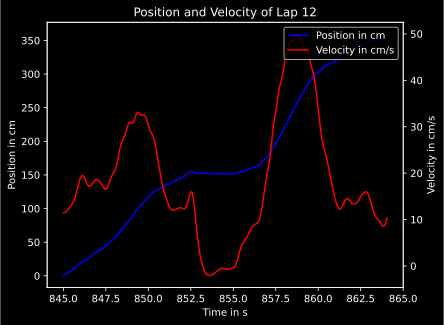

In [10]:
%matplotlib inline

lap_oi = 12 #adjust here

position_lap_oi = position[lap==lap_oi]
velocity_lap_oi = velocity[lap==lap_oi]
time_lap_oi = time[lap==lap_oi]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(time_lap_oi,position_lap_oi,label='Position in cm',color = 'blue')
ax1.set_ylabel('Position in cm')
ax2.plot(time_lap_oi,velocity_lap_oi,label='Velocity in cm/s',color='red')
ax2.set_ylabel('Velocity in cm/s')
ax1.set_xlabel('Time in s')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
ax1.set_title('Position and Velocity of Lap ' + str(lap_oi))


# Does the velocity of the animal correlate with the animal's postition on the belt?

Let's plot a visualization!  



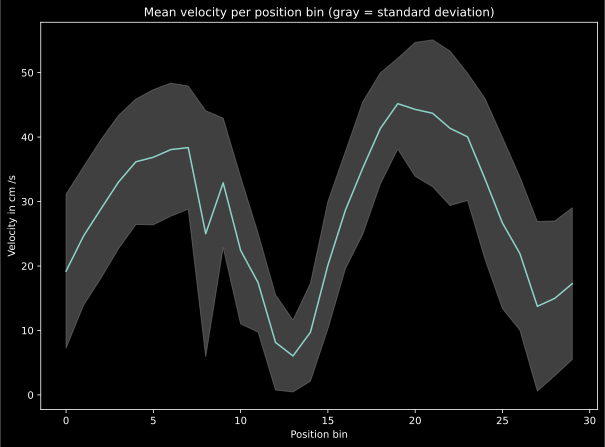

In [11]:
# Let's first bin the speed signal in position bins:
binwidth = 12 # cm
beltlength = 360 # cm
numBins = beltlength/binwidth
Bin_edges = np.arange(0,beltlength,binwidth) # boarders of position bins
velocity1 = pd.DataFrame(velocity)
position = pd.DataFrame(position)
velocity1.loc[:,'Bin'] = np.digitize(position,Bin_edges)-1 # to make it start at 0
mean_binned_velocity = velocity1.groupby('Bin').mean()
std_binned_velocity = velocity1.groupby('Bin').std()

fig, ax = plt.subplots(1, figsize=(10, 7))

# Convert pandas Series to NumPy arrays or access the underlying values
mean_velocity_values = mean_binned_velocity.values.flatten()
std_velocity_values = std_binned_velocity.values.flatten()

ax.plot(mean_binned_velocity.index, mean_velocity_values)
ax.fill_between(mean_binned_velocity.index, mean_velocity_values - std_velocity_values, mean_velocity_values + std_velocity_values, color='gray', alpha=0.5)

# Additional customization and labeling
ax.set_xlabel('Position bin')
ax.set_ylabel('Velocity in cm /s')
ax.set_title('Mean velocity per position bin (gray = standard deviation)')

plt.show()


# Now let's load the neural data and explore the deconvolved calcium signal of some cells!

In this tutorial we will use the deconvolved event traces that were calculated with CNMF to avoid differential effects of
GCaMP6s calcium signal tails at different animal velocities
across space.


Text(0, 0.5, 'deconvolved calcium signal')

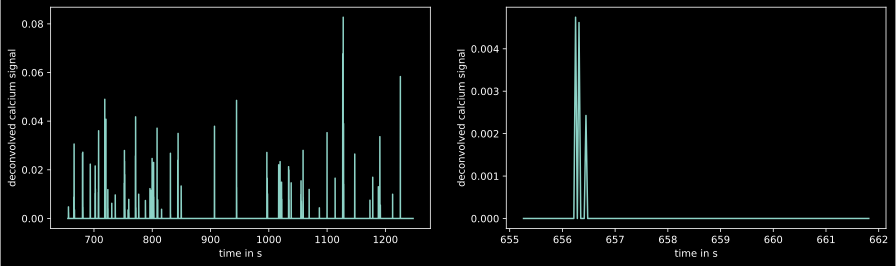

In [12]:
# plot calcium signal of single cell
#calcium_signal = behaviour_calcium['cell']
column_names = list(range(977))  # Column names 0, 1, 2, 3, ...
calcium_signal = pd.DataFrame(calcium.T, columns=column_names)


cell_oi = 934

fig, ax = plt.subplots(1,2,figsize = (15,4))
ax[0].plot(time,calcium_signal[cell_oi])
ax[0].set_xlabel('time in s')
ax[0].set_ylabel('deconvolved calcium signal')

# zoom in plot
ax[1].plot(time[:200],calcium_signal[cell_oi][:200]) # Adjust to where you want to zoom
ax[1].set_xlabel('time in s')
ax[1].set_ylabel('deconvolved calcium signal')


# Let's find some place cells !

There are multiple definitions about how you define a placecell as being a 'placecell'. We will show one way in the following.

At first let's calculate the mean signal of position bins across the treadmill belt for each lap, the overall mean activity of each cell as well as the mean occupancy which we need for the calculation of spatial information (see next cell). Note that for place cell discovery we will only use signal where the animal is actualy moving, i.e. where its velocity is above velocity threshold v_thresh.

In [13]:
binwidth = 12 # cm
beltlength = 360 # cm
numBins = beltlength/binwidth
v_thresh = 2 # cm/s
Bin_edges = np.arange(0,beltlength,binwidth) # boarders of position bins


# Include behavioural data in the dataframe to makes things comfortable:

calcium_signal.loc[:,'Position'] = position
calcium_signal.loc[:,'Velocity'] = velocity
calcium_signal.loc[:,'Lap'] = lap
calcium_signal_run = calcium_signal[velocity>v_thresh]
calcium_signal_run = calcium_signal_run[lap>min(lap)+2] # exclude first three laps where artifacts happen
calcium_signal_run = calcium_signal_run[lap <max(lap)] # exclude last lap because there the belt is not fully covered.
calcium_signal_run.loc[:,'Bin'] = np.digitize(calcium_signal_run.Position,Bin_edges)-1 # to make it start at 0
calcium_signal_run = calcium_signal_run.reset_index(drop=True)



# loop through each cell to calculate binned signal
# bin signal using pandas 'pivot' function.
# Also count the datapoints per in and multiply with dt in order to obtain
# occupancy per bin

def bin_signal(signal):

    binned_signal = signal.groupby('Bin').mean()[:cell_num]

    mean_signal = signal.mean()[:cell_num]

    occupancy = signal.groupby('Bin').count()[0]

    occupancy_prob = occupancy/np.sum(occupancy)

    return binned_signal, occupancy, occupancy_prob, mean_signal


binned_signal, occupancy, occupancy_prob, mean_signal = bin_signal(calcium_signal_run)



# Let us calculate mutual information place and the cell's activity:

In this case mutual information SI is defined as $$
SI = \sum_{i} o_{i} \cdot \frac{a_{i}}{\overline{a}} \cdot \log_{2} \left( \frac{a_{i}}{\overline{a}} \right)
$$ where i denotes the i-th spatial bin, oi is the animal’s relative occupancy of spatial bin i, ai is the mean calcium activity at spatial bin i, and a¯ is the overall mean calcium activity of the respective cell. Note that SI is a conservative measure and usable for scenarios where we expect mainly one placefield per place cell. Some hippocampal cells with several clear place fields for example may have less spatial information overall althogh they are  spatially tuned. From now on let's call this mutual information the cell's 'place score'

In [14]:
def calculate_placescore(binned_signal,occupancy_prob,mean_signal):
  score = (occupancy_prob * (binned_signal/mean_signal).T) * np.real(
        np.log2((binned_signal / mean_signal))).T

  placescore = score.sum(axis=1)

  return placescore

placescore = calculate_placescore(binned_signal,occupancy_prob,mean_signal)


# Criterion 1: Place score percentile rank

 One criterion for defining a place cell is place score percentile. It is calculated by shuffling the signal of the cells N times (typically N= 1000 - here, due to computation time reasons N = 100) on the time axis. Then we calculate the placescore for each shuffled signal, to see how likely it is that we obtained a high placescore just by chance. When place score value of the actual signal is far out from distribution mean, i.e. percentile > 0.95, the place score is likely not just that high "by chance".

In [15]:
TableToShift = calcium_signal_run
NumBlocks = max(lap)
blocklen = int(len(calcium_signal_run)/NumBlocks)
iters = 100

def shuffle_blocks(column, blocklen):
      values = column.values
      num_blocks = len(column) // blocklen
      remaining_values = len(column) % blocklen

      # Shuffle complete blocks
      if num_blocks > 0:
          blocks = values[:num_blocks * blocklen].reshape(num_blocks, blocklen)
          np.random.shuffle(blocks)
          values[:num_blocks * blocklen] = blocks.ravel()

      # Shuffle any remaining values
      if remaining_values > 0:
          remaining = values[num_blocks * blocklen:]
          np.random.shuffle(remaining)
          values[num_blocks * blocklen:] = remaining

      return pd.Series(values)


placescore_shuffled = {}
for i in tqdm(range(0,iters), desc="Iterating across shuffles"):
  # 1: Circular Shifting with > 500 Frames:
  IndexShift = int(np.random.uniform(low=500, high=(len(calcium_signal_run.index) - 500), size=1))
  ShiftTable = TableToShift.reindex(index=np.roll(TableToShift.index, IndexShift)).reset_index(drop=True)

  # Apply the shuffle_blocks function to all column
  ShuffledTable = ShiftTable.apply(shuffle_blocks, args=(blocklen,), axis=0)

  #ShuffledTable.reset_index(drop=True, inplace=True)
  calcium_signal_run1 = calcium_signal_run.copy()
  calcium_signal_run1.reset_index(drop=True, inplace=True)

  ShuffledTable = ShuffledTable.drop('Bin',axis=1)
  ShuffledTable['Bin'] = calcium_signal_run1['Bin']
  # Calculate binned signal for shuffled dataframe
  binned_signal1, occupancy1, occupancy_prob1, mean_signal1 = bin_signal(ShiftTable)

  # Calculate place score
  placescore_shuffled[i] = calculate_placescore(binned_signal1,occupancy_prob1,mean_signal1)

Iterating across shuffles: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


Let's find the cell indices with a percentile higher than 95:

In [16]:
from scipy import stats
placescore = placescore[:cell_num]
threshold= 95 # the placescore of the original signal should be higher than
# 95 percent of shuffled ones

percentiles = {}
percentile_rank = {}
for i in range(0,cell_num):
    values_at_position = [placescore_shuffled[arr_name][i] for arr_name in placescore_shuffled]
    percentile_95 = np.percentile(values_at_position, threshold)
    percentiles[i] = percentile_95
    percentile_rank[i] = stats.percentileofscore(values_at_position, placescore[i])


# Compare values in placescore with the calculated percentiles to identify higher values
indices_placecells = [i for i, test_value in enumerate(placescore) if test_value > percentiles[i]]

# Print the indices where values in placescore are higher
print("Indices where placescore values are higher than", str(threshold), "th percentile:")
print(indices_placecells)



Indices where placescore values are higher than 95 th percentile:
[1, 3, 4, 8, 10, 22, 24, 25, 26, 29, 31, 35, 45, 46, 48, 49, 50, 51, 53, 54, 55, 58, 64, 65, 70, 72, 78, 79, 80, 82, 83, 86, 88, 91, 94, 95, 96, 100, 102, 105, 106, 108, 110, 115, 116, 117, 118, 121, 122, 127, 129, 130, 139, 140, 141, 142, 148, 150, 155, 157, 159, 160, 162, 163, 168, 171, 175, 177, 183, 185, 188, 189, 194, 199, 203, 205, 211, 217, 219, 224, 229, 230, 233, 235, 236, 246, 248, 257, 259, 262, 265, 270, 272, 278, 282, 285, 287, 291, 294, 297, 299, 300, 302, 308, 311, 315, 318, 320, 325, 326, 327, 331, 339, 342, 344, 351, 352, 358, 363, 367, 369, 375, 377, 380, 384, 386, 388, 391, 396, 398, 401, 407, 411, 413, 414, 415, 418, 419, 421, 424, 428, 433, 436, 437, 440, 442, 444, 449, 452, 454, 457, 458, 462, 469, 475, 479, 480, 481, 482, 485, 490, 491, 493, 514, 516, 525, 528, 530, 531, 532, 533, 543, 545, 547, 548, 557, 559, 561, 568, 570, 573, 575, 580, 583, 587, 590, 592, 593, 602, 605, 618, 619, 624, 626, 633,

#Let's visualize the place tuning of the cells!

 Use the slider to change place cells. In the title you can see the cell's percentile rank compared to population of placescores from the shuffled signal we just calculated.


In [17]:
# Disable scrolling in output cell
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Assuming you already have calcium_signal_run defined

# Precompute the data for all cells
all_cell_data = {}
num_columns = len(calcium_signal_run.columns)
above_below = []
for cell_oi in range(cell_num):
    calcium_signal_run_celloi = calcium_signal_run[[cell_oi, 'Lap', 'Bin']]
    calcium_signal_laps = calcium_signal_run_celloi.pivot_table(index='Lap', columns='Bin', values=cell_oi, aggfunc='mean')
    all_cell_data[cell_oi] = calcium_signal_laps
    if cell_oi in indices_placecells:
      above_below.append('above')
    else:
      above_below.append('below')


# Define a function to update the plot based on the selected cell index
def update_plot(cell_oi=0):
    if cell_oi < num_columns:  # Check if cell_oi is within valid range
        plt.clf()  # Clear the previous plot
        calcium_signal_laps = all_cell_data[cell_oi]

        cmap = plt.get_cmap('viridis')

        fig, ax = plt.subplots(3, figsize=(6, 8))
        for i in range(np.shape(calcium_signal_laps)[0]):
            color = cmap(i / (np.shape(calcium_signal_laps)[0] - 1))
            ax[0].plot(np.array(calcium_signal_laps)[i, :], color=color, label=f'Row {i}')
            ax[0].set_xlabel('Position Bin')
            ax[0].set_ylabel('Calcium signal')
            ax[0].set_title('Calcium Signal Over Laps of cell ' + str(cell_oi) + ' pct_rank =' + str(percentile_rank[cell_oi])+'%')

        ax[1].imshow(calcium_signal_laps, cmap='jet', aspect='auto')
        ax[1].set_xlabel('Position Bin')
        ax[1].set_ylabel('Lap')

        ax[2].plot(np.mean(calcium_signal_laps, axis=0))
        ax[2].set_xlabel('Position Bin')
        ax[2].set_ylabel('Mean Calcium Signal')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Invalid cell index. Please select a valid index between 0 and {num_columns - 1}.")

# Use matplotlib's built-in interactive features
plt.ion()

# Create an interactive slider with step size 1 and a longer range
from ipywidgets import interact
interact(update_plot, cell_oi=(0, num_columns - 1, 1), continuous_update=False, step=1)





<IPython.core.display.Javascript object>

interactive(children=(IntSlider(value=0, description='cell_oi', max=980), Output()), _dom_classes=('widget-int…

<function __main__.update_plot(cell_oi=0)>

When exploring a bit you can see that for some cells, there is higher activity in multiple relatively wide fields. These cells have a high percentile due to the spatial selectivity of their activity, but they might potentially be tuned to speed rather than place. Note that the speed of the animal highly correlates also with the position of the animal on the treadmill. Thus let us also quantify the cells speed tuning and see if we can still distinguish speed tuned cells from place tuned cells somehow.


#Let's visualize the speed tuning of the cells!

Similar as to how we did it with calculating place information, we bin the signal in speed bins.

In [20]:
binwidth = 1 # cm/s
v_thresh = 2 # cm/s
Speed_Bin_edges = np.arange(v_thresh,max(velocity),binwidth) # borders of position bins


# Include behavioural data in the dataframe to makes things comfortable:
calcium_signal_run.loc[:,'SpeedBin'] = np.digitize(calcium_signal_run.Velocity,Speed_Bin_edges)-1 # to make it start at0
calcium_signal_run = calcium_signal_run.reset_index(drop=True)

# loop through each cell to calculate binned signal
# bin signal using pandas 'pivot' function.
# Also count the datapoints per in and multiply with dt in order to obtain
# occupancy per bin

def speed_bin_signal(signal):

    speed_binned_signal = signal.groupby('SpeedBin').mean()[:cell_num]

    return speed_binned_signal


speed_binned_signal = speed_bin_signal(calcium_signal_run)

#Let's compare the speed and position tuning of single cells:

Investigate the cells by changing their indices with the slider. Many cells that are place tuned also show significant speed tuning. In these cases -do you think it is rather a place cell, a speed cell, or a cell tuned by both behavioural parameters?

Keep in mind that we also have even more behavioural parameters that cells could code for, such as reward, licking etc and that neurons might not neccessarily code for one variable only but jointly for multiple ones, since the hippocampus was found to encode not only space information but also other behavioural and abstract task relevant variables (see e.g. Nieh et al. 2021).

One way to investigate the tuning for multiple stimuli and behavioural variables is to use statistical tools such as Generalized linear models. Here you can add regularization methods to account for collinearity of your regressors. Note however, that these models can struggle with too much collinearity as well. Thus you should try to keep the correlation among the stimuli/ behavioural variables as low as possible.

If your objective is for example to clearly investigate speed tuned cells vs. position tuned cells, the best way would be to change your experimental design such that you decouple velocity from position.

To invesigate how the neuronal population codes for combinations of behaviourally relevant variables, we can use dimensionality reduction methods. See e.g. Nieh et al., (Nature, 2021).

Note that both the encoding properties of neurons as well as your choice of analysis always depend highly on the task at hand.



In [21]:
import seaborn as sns
def update_plot(cell_oi=0):
    if cell_oi < num_columns:  # Check if cell_oi is within valid range
        plt.clf()  # Clear the previous plot
        calcium_signal_laps = all_cell_data[cell_oi]

        cmap = plt.get_cmap('viridis')

        fig, ax = plt.subplots(2,2, figsize=(12, 8))


        ax[0,0].imshow(calcium_signal_laps, cmap='jet', aspect='auto')
        ax[0,0].set_xlabel('Position Bin')
        ax[0,0].set_ylabel('Lap')
        ax[0,0].set_title('Calcium Signal Over Laps of cell ' + str(cell_oi) + ' pct_rank =' + str(percentile_rank[cell_oi])+'%')


        ax[1,0].plot(np.mean(calcium_signal_laps, axis=0))
        ax[1,0].set_xlabel('Position Bin')
        ax[1,0].set_ylabel('Mean Calcium Signal')
        ax[1,0].set_title('Mean Position binned Signal')

        ax[1,1].plot(mean_binned_velocity.index, mean_velocity_values)
        ax[1,1].fill_between(mean_binned_velocity.index, mean_velocity_values - std_velocity_values, mean_velocity_values + std_velocity_values, color='gray', alpha=0.5)

        sns.scatterplot(x=speed_binned_signal.index, y=speed_binned_signal[cell_oi], label='Data Points',ax=ax[0,1])
        ax[0,1].set_xlabel('Speed in cm/s')
        ax[0,1].set_ylabel('mean binned signal')
        ax[0,1].set_title('Mean activity vs velocity')

        ax[1,1].set_xlabel('Position bin')
        ax[1,1].set_ylabel('Velocity in cm /s')
        ax[1,1].set_title('Mean velocity per position bin (gray = standard deviation)')


        plt.tight_layout()
        plt.show()
    else:
        print(f"Invalid cell index. Please select a valid index between 0 and {num_columns - 1}.")

# Use matplotlib's built-in interactive features
plt.ion()

# Create an interactive slider with step size 1 and a longer range
from ipywidgets import interact
interact(update_plot, cell_oi=(0, num_columns - 1, 1), continuous_update=False, step=1)


interactive(children=(IntSlider(value=0, description='cell_oi', max=980), Output()), _dom_classes=('widget-int…

<function __main__.update_plot(cell_oi=0)>

# BONUS: Calculate the place cells' placefield and firing reliability

Here, we obtain place fields by replicating the binned_signal trace by a factor of 3 to account for circularity of the belt. Then we apply a Savitzky-Golay filter to account for skewed place field activity (here we use window_length of 8. Note that the bigger the window_length, the 'smoother' the signal). The more classical way would just be to use a Gaussian filter for smoothing which doesn't consider the "skewing" of PFs however.

The resulting filtered spatial calcium activity is then searched for peaks using Scipy’s find_peaks function. In this function you can adjust characteristics of your peaks to account for a place field. (Here: min width: numBins/20; relative height: 0.7;  min peak distance = numBins/20)

The left/right interpolated intersection points are defined as place field beginning/end.



In [22]:
import ipywidgets as widgets

def calculate_placefields(cell_oi):
    binned_signal_concatenated = np.array([[binned_signal[cell_oi]] * 3]).flatten()
    filtered_signal = savgol_filter(binned_signal_concatenated, window_length=int(numBins/3), polyorder=2)
    filtered_signal_normalized = filtered_signal / np.max(filtered_signal)

    peak_info = sig.find_peaks(filtered_signal_normalized, width=numBins/20, height=0.7, distance=numBins/20)

    if len(peak_info[0]) > 0:
        peak_heights = peak_info[1]['peak_heights']
        PF_peak_locations = peak_info[0]
        PF_peak_height = np.max(peak_heights)
        PF_idx = np.where((peak_heights == PF_peak_height))
        PF_peak_width = peak_info[1]['widths']

        PF_left_edge = np.ceil(peak_info[1]['left_ips'])
        PF_right_edge = np.ceil(peak_info[1]['right_ips'])
    else:
        PF_left_edge = []
        PF_right_edge = []

    return peak_info, binned_signal_concatenated, filtered_signal, PF_left_edge, PF_right_edge

# Create a slider widget for cell_oi
cell_oi_slider = widgets.IntSlider(min=0, max=cell_num, step=1, value=0)

# Create an output widget for displaying the plot
output = widgets.Output()

# Function to update the plot when the slider value changes
def update_plot(change):
    cell_oi = change.new
    with output:
        output.clear_output()
        peak_info, binned_signal_concatenated, filtered_signal, PF_left_edge, PF_right_edge = calculate_placefields(cell_oi)

        fig, ax = plt.subplots(figsize=(10, 8))
        line1, = ax.plot(filtered_signal)
        line2, = ax.plot(binned_signal_concatenated)

        if len(peak_info[0]) > 0:
          if cell_oi in indices_placecells:
            for x in range(len(PF_right_edge)):
                line3, = ax.plot([PF_left_edge[x], PF_right_edge[x]], [0, 0], color='blue', linewidth=10)
          else:
            line3, = ax.plot([PF_left_edge[0], PF_right_edge[0]], [0, 0], color='blue', linewidth=10,alpha=0)

        ax.set_xlim([numBins - 1, numBins * 2 - 1])  # Adjust the x-axis limits as needed
        ax.legend([line1, line2, line3], ['filtered_signal', 'original_binned_signal', 'placefield'])
        ax.set_ylabel('binned signal')
        ax.set_xlabel('Position Bins')
        ax.set_title('Middle segment of concatenated binned position signal with place field of cell ' + str(cell_oi))

        plt.show()

# Attach the update_plot function to the slider's value change event
cell_oi_slider.observe(update_plot, 'value')

# Create a layout for the widgets
ui = widgets.VBox([cell_oi_slider, output])

# Display the widgets
display(ui)

We can now calculate the reliability of place fields in the next step, i.e. in how many laps the mean inside the palce fields was at least 1.5 times higher than outside the place fields. We can define cells that have a percentage of laps where this is true as 'reliable'.

**But caution!**
Keep in mind the valocity tuning argument from above.
Also note also that there might be **plasticity effects** of PCs changing their place fields to another location or developing a place field later! In order to account for this, one could use sliding windows and calculate the stability in the sliding windows - However, for now let's assume place fields should be relatively stable across laps, since the animal is not learning a spatial representation any more during the recording, but has learned it before already.

In [ ]:
# Let's first compute the bins that are in the placefield:
PF_indices = {}

for cell_oi in indices_placecells:
  peak_info, binned_signal_concatenated, filtered_signal, PF_left_edge, PF_right_edge = calculate_placefields(cell_oi)

  PF_indices1 = []
  for x in range(len(PF_right_edge)):
    if PF_left_edge[x]>PF_right_edge[x]:
      PF_indices1.extend(list(np.arange(np.floor(PF_left_edge[x]),np.ceil(numBins)+1)))
      PF_indices1.extend(list(np.arange(0,np.ceil(PF_right_edge[x])+1)))

    else:
      PF_indices1.extend(list(np.arange(np.floor(PF_left_edge[x]), np.ceil(PF_right_edge[x])+1)))

  PF_indices[cell_oi] = PF_indices1
  PF_indices[cell_oi] = [int(x) for x in PF_indices[cell_oi]]
  mask = np.array(PF_indices[cell_oi])<numBins
  PF_indices[cell_oi] = np.array(PF_indices[cell_oi])[mask]


# find peaks of PF activity per lap

mean_value_inside_PF = np.zeros([cell_num,max(lap)])
mean_value_total = np.zeros([cell_num,max(lap)])
percentage = np.zeros(cell_num)

# All entries without -1 that will be filled have a valid peak and a Percentile >95 percent

for cell_oi in indices_placecells:
  calcium_signal_run_celloi = calcium_signal_run[[cell_oi,'Lap','Bin']]
  calcium_signal_laps = calcium_signal_run_celloi.pivot_table(index='Lap', columns='Bin', values=cell_oi, aggfunc='mean')

  count = 0
  for l in list(calcium_signal_laps.index):
    mean_value_inside_PF[cell_oi][l] = np.mean(calcium_signal_laps.T[l][list(PF_indices[cell_oi])])
    mean_value_total[cell_oi][l] = np.mean(calcium_signal_laps.T[l])

    if mean_value_inside_PF[cell_oi][l]/np.max(mean_value_total[cell_oi][l])>1.5*(mean_value_total[cell_oi][l]/np.max(mean_value_total[cell_oi][l])):
      count = count+1

  percentage[cell_oi] = count/len(calcium_signal_laps.index)

# Let's define a high reliability at 0.4. (Note that this is a matter of definition.)
indices_high_reliability = np.where(percentage>0.4)[0]
print(indices_high_reliability)


[  3   4   8  10  22  24  25  35  48  50  51  54  55  58  65  72  78  82
  95 100 102 105 110 117 148 160 163 168 171 175 190 194 229 230 236 246
 257 327 342 352 358 369 375 391 414 419 421 424 440 458 479 533 573 590
 647 651 671 702 727 734 759 780 784 823 849 865 875 907 909 915 919 928
 935]


# Let's plot the distribution of stable spatially tuned cells as well as the one of all spatially tuned cells (cells with Pct>95)


In [ ]:
import seaborn as sns
# Let's sort them after the peaks of their mean activity.
stable_pcs_mean_signal = binned_signal[indices_high_reliability].reset_index()
pcs_mean_signal = binned_signal[indices_placecells].reset_index()

# Sort the DataFrame by the 'max_value' column
max_position_stable = stable_pcs_mean_signal.idxmax()
sorted_cells_stable = max_position_stable.sort_values(ascending=False).index
max_position = pcs_mean_signal.idxmax()
sorted_cells = max_position.sort_values(ascending=False).index

# Create a sorted DataFrame
stable_pcs_sorted = stable_pcs_mean_signal[sorted_cells_stable]
pcs_sorted = pcs_mean_signal[sorted_cells]

# normalize the mean signal
stable_pcs_sorted_normalized = stable_pcs_sorted.apply(lambda x: x / x.max(), axis=0)
pcs_sorted_normalized = pcs_sorted.apply(lambda x: x / x.max(), axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,8))
sns.heatmap(stable_pcs_sorted_normalized.T,ax=ax[0],cmap='jet')
ax[0].set_title('"Stable" place cells')
sns.heatmap(pcs_sorted_normalized.T,ax=ax[1],cmap='jet')
ax[1].set_title('All cells with place score pct > 0.95')

Text(0.5, 1.0, 'All cells with place score pct > 0.95')